Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.83502 154.469; 7.66315 154.319; … ; 7.50048 155.074; 7.40337 155.048]

Union{Missing, Float64}[7.73838 154.891; 7.33231 154.418; … ; 7.63373 154.529; 8.07892 155.597]

Union{Missing, Float64}[7.82854 154.784; 7.54661 154.594; … ; 7.9145 155.241; 7.5519 154.043]

Union{Missing, Float64}[7.96909 155.409; 7.87693 154.03; … ; 8.38401 154.419; 8.21992 153.838]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
sigma   7.776756 0.30141481 0.0047657866 0.0045406388 1000
   mu 154.593501 0.41417658 0.0065487067 0.0065832216 1000

Quantiles:
          2.5%       25.0%      50.0%      75.0%       97.5%  
sigma   7.2069305   7.5648675   7.76634   7.9722225   8.404094
   mu 153.7799500 154.3197500 154.59800 154.8800000 155.402050



Plot the density of posterior draws

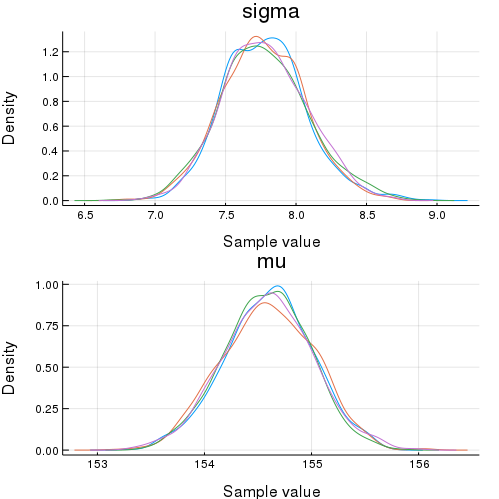

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.16439923630730696
 0.08689473900678592

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0        -0.0325393
 -0.0325393   1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*